# Probabilistic Labels Comparison

Compare kNN probabilistic labels from different BYOL embeddings.

This notebook:
1. Loads embeddings from two different experiments (e.g., fiducial vs broadband-only)
2. Applies the same PCA and kNN configuration to both
3. Generates probabilistic labels using identical train/test splits
4. Compares classification performance and label distributions
5. Visualizes differences in merger classification

**Use cases:**
- Compare fiducial (g, i, hf_i) vs broadband-only (g, i, i) embeddings
- Test different PCA dimensionalities
- Compare different kNN parameters
- Evaluate impact of different training strategies

## Setup and Imports

In [1]:
import os
os.chdir('/Users/kadofong/work/projects/merian/pieridae/merger_analysis/notebooks')

In [318]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pickle
from typing import Dict, Tuple

from pieridae.starbursts.byol import (
    EmbeddingAnalyzer,
    LabelPropagation,
    compute_classification_metrics
)

# Plotting utilities
from ekfplot import plot as ek, colors as ec, colorlists

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
def load_image_by_name(img_name: str, data_path: Path) -> np.ndarray:
    """
    Load a single galaxy image on-demand.
    
    Parameters
    ----------
    img_name : str
        Galaxy ID (e.g., 'M1234567890123456789')
    data_path : Path
        Base data directory path
    
    Returns
    -------
    image : np.ndarray
        Image array with shape (3, H, W) containing [g-band, i-band, hf_i-band]
    """
    i_file = data_path / img_name / f"{img_name}_i_results.pkl"
    g_file = data_path / img_name / f"{img_name}_g_results.pkl"
    
    img = []
    for band_file in [g_file, i_file]:
        with open(band_file, 'rb') as f:
            xf = pickle.load(f)
            img.append(xf['image'])
            if band_file == i_file:
                img.append(xf['hf_image'])  # Add HF image for i-band
    
    return np.array(img, dtype=np.float32)

print("✅ Image loading helper function defined")

✅ Image loading helper function defined


## Configuration

In [3]:
# Load shared config
config_path = '../config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(f"📋 Configuration loaded from: {config_path}")

📋 Configuration loaded from: ../config.yaml


In [9]:
# Define experiments to compare
experiments = {
    'fiducial': {
        'path': Path('../output/fiducial'),
        'label': 'Fiducial (g, i, hf_i)',
        'color': 'C0',
        'description': 'Standard analysis with high-frequency features'
    },
    'bbonly': {
        'path': Path('../output/bbonly_test/'),
        'label': 'Broadband Only (g, i, i)',
        'color': 'C1',
        'description': 'Broadband-only without HF decomposition'
    }
}

print("📂 Experiment paths:")
for name, exp in experiments.items():
    print(f"   {name}: {exp['path']}")
    print(f"      {exp['description']}")

📂 Experiment paths:
   fiducial: ../output/fiducial
      Standard analysis with high-frequency features
   bbonly: ../output/bbonly_test
      Broadband-only without HF decomposition


In [10]:
# Analysis parameters (applied to BOTH experiments for fair comparison)
analysis_config = {
    'pca_components': config['analysis'].get('pca_components', 10),
    'variance_threshold': config['analysis'].get('explained_variance_threshold', 0.95),
    'n_neighbors': config['labels'].get('n_neighbors', 50),
    'n_min': config['labels'].get('minimum_labeled_neighbors', 5),
    'n_min_auto': config['labels'].get('minimum_labeled_neighbors_for_autoprop', 10),
    'prob_threshold': config['labels'].get('prob_threshold', 0.9),
    'frag_threshold': config['labels'].get('frag_threshold', 0.25),
    'random_seed': config['advanced'].get('random_seed', 42),
    'train_fraction': 0.3  # For creating train/test split
}

print("⚙️  Analysis configuration (applied to both experiments):")
for key, val in analysis_config.items():
    print(f"   {key}: {val}")

⚙️  Analysis configuration (applied to both experiments):
   pca_components: 10
   variance_threshold: 0.95
   n_neighbors: 50
   n_min: 5
   n_min_auto: 10
   prob_threshold: 0.7
   frag_threshold: 0.25
   random_seed: 28
   train_fraction: 0.3


## Load Embeddings and Labels

In [11]:
def load_experiment_data(exp_path: Path) -> Dict:
    """
    Load embeddings and metadata from an experiment directory.
    
    Parameters
    ----------
    exp_path : Path
        Path to experiment output directory
    
    Returns
    -------
    data : dict
        Dictionary containing:
        - embeddings_original: Raw BYOL embeddings
        - img_names: Galaxy identifiers
        - embeddings_pca: PCA embeddings (if available)
        - pca: Fitted PCA model (if available)
        - scaler: Fitted scaler (if available)
    """
    # Try loading from dimensionality reduction results first
    dim_file = exp_path / 'dimensionality_reduction_results.pkl'
    bbonly_file = exp_path / 'dimensionality_reduction_results_bbonly.pkl'
    
    if dim_file.exists():
        with open(dim_file, 'rb') as f:
            data = pickle.load(f)
        print(f"   Loaded from: {dim_file}")
    elif bbonly_file.exists():
        with open(bbonly_file, 'rb') as f:
            data = pickle.load(f)
        print(f"   Loaded from: {bbonly_file}")
    else:
        # Fallback: load raw embeddings
        embeddings_file = exp_path / 'embeddings.npy'
        if not embeddings_file.exists():
            raise FileNotFoundError(f"No embeddings found in {exp_path}")
        
        embeddings = np.load(embeddings_file)
        data = {
            'embeddings_original': embeddings,
            'img_names': None  # Will need to load separately
        }
        print(f"   Loaded raw embeddings from: {embeddings_file}")
    
    return data

print("✅ Data loading function defined")

✅ Data loading function defined


In [12]:
# Load data from both experiments
data = {}

for name, exp in experiments.items():
    print(f"\nLoading {name} experiment...")
    try:
        data[name] = load_experiment_data(exp['path'])
        print(f"   Embeddings shape: {data[name]['embeddings_original'].shape}")
        print(f"   Image names: {len(data[name]['img_names'])} objects")
    except FileNotFoundError as e:
        print(f"   ⚠️  {e}")
        print(f"   Skipping {name} experiment")

if len(data) < 2:
    print("\n⚠️  Warning: Need at least 2 experiments to compare!")
else:
    print(f"\n✅ Loaded {len(data)} experiments for comparison")


Loading fiducial experiment...
Fri Oct 17 12:42:22 2025 Building and compiling search function
   Loaded from: ../output/fiducial/dimensionality_reduction_results.pkl
   Embeddings shape: (22913, 512)
   Image names: 22913 objects

Loading bbonly experiment...
Fri Oct 17 12:42:23 2025 Building and compiling search function
   Loaded from: ../output/bbonly_test/dimensionality_reduction_results_bbonly.pkl
   Embeddings shape: (22913, 512)
   Image names: 22913 objects

✅ Loaded 2 experiments for comparison


In [13]:
# Verify that both experiments have the same galaxies
exp_names = list(data.keys())
if len(exp_names) >= 2:
    img_names_0 = data[exp_names[0]]['img_names']
    img_names_1 = data[exp_names[1]]['img_names']
    
    if not np.array_equal(img_names_0, img_names_1):
        print("⚠️  Warning: Experiments have different galaxy sets!")
        print(f"   {exp_names[0]}: {len(img_names_0)} galaxies")
        print(f"   {exp_names[1]}: {len(img_names_1)} galaxies")
        
        # Find common galaxies
        common_names = np.intersect1d(img_names_0, img_names_1)
        print(f"   Common galaxies: {len(common_names)}")
        
        # Subset to common galaxies
        for name in exp_names:
            mask = np.isin(data[name]['img_names'], common_names)
            data[name]['embeddings_original'] = data[name]['embeddings_original'][mask]
            data[name]['img_names'] = data[name]['img_names'][mask]
        
        img_names = common_names
        print(f"   ✅ Subset to {len(img_names)} common galaxies")
    else:
        img_names = img_names_0
        print(f"✅ Both experiments have the same {len(img_names)} galaxies")
else:
    img_names = data[exp_names[0]]['img_names']

✅ Both experiments have the same 22913 galaxies


## Load Classification Labels

In [14]:
# Load ground truth labels
label_file = Path(config.get('labels', {}).get('classifications_file', ''))

if label_file.exists():
    mergers = pd.read_csv(label_file, index_col=0)
    labels = mergers.reindex(img_names)
    labels = labels.replace(np.nan, 0).values.flatten().astype(int)
    
    print(f"✅ Loaded {len(labels)} labels")
    
    # Print distribution
    label_meanings = config.get('labels', {}).get('label_mapping', {})
    unique, counts = np.unique(labels, return_counts=True)
    
    print("\n📊 Label distribution:")
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        pct = 100 * count / len(labels)
        print(f"   {label_val} ({meaning}): {count} objects ({pct:.1f}%)")
else:
    print(f"⚠️  Label file not found: {label_file}")
    labels = np.zeros(len(img_names), dtype=int)

✅ Loaded 22913 labels

📊 Label distribution:
   0 (unclassified): 19960 objects (87.1%)
   1 (undisturbed): 2314 objects (10.1%)
   2 (ambiguous): 214 objects (0.9%)
   3 (merger): 96 objects (0.4%)
   4 (fragmentation): 280 objects (1.2%)
   5 (artifact): 49 objects (0.2%)


## Apply PCA to Both Experiments

In [16]:
# Apply PCA with identical settings
for name in data.keys():
    print(f"\nComputing PCA for {name}...")
    
    # Create analyzer with shared config
    temp_config = config.copy()
    temp_config['analysis']['pca_components'] = analysis_config['pca_components']
    temp_config['analysis']['explained_variance_threshold'] = analysis_config['variance_threshold']
    
    analyzer = EmbeddingAnalyzer(temp_config)
    embeddings_pca = analyzer.compute_pca(
        data[name]['embeddings_original'],
        n_components=analysis_config['pca_components']
    )
    
    # Store results
    data[name]['embeddings_pca'] = embeddings_pca
    data[name]['pca'] = analyzer.pca
    data[name]['scaler'] = analyzer.scaler
    
    explained_var = analyzer.pca.explained_variance_ratio_.sum() * 100
    print(f"   PCA components: {embeddings_pca.shape[1]}")
    print(f"   Explained variance: {explained_var:.1f}%")

print("\n✅ PCA complete for all experiments")

2025-10-17 12:44:42,791 - INFO - Computing PCA...



Computing PCA for fiducial...


2025-10-17 12:44:43,029 - INFO - PCA components: 10
2025-10-17 12:44:43,029 - INFO - Explained variance: 85.7%
2025-10-17 12:44:43,032 - INFO - Computing PCA...
2025-10-17 12:44:43,211 - INFO - PCA components: 10
2025-10-17 12:44:43,212 - INFO - Explained variance: 86.5%


   PCA components: 10
   Explained variance: 85.7%

Computing PCA for bbonly...
   PCA components: 10
   Explained variance: 86.5%

✅ PCA complete for all experiments


## Run Label Propagation

In [61]:
# Run iterative label propagation for both experiments
for name in data.keys():
    print(f"\n{'='*70}")
    print(f"Label propagation: {name}")
    print(f"{'='*70}")
    
    propagator = LabelPropagation(
        n_neighbors=analysis_config['n_neighbors'],
        n_min=analysis_config['n_min'],
        n_min_auto=analysis_config['n_min_auto'],
        prob_threshold=analysis_config['prob_threshold'],
        frag_threshold=analysis_config['frag_threshold'],
    )
    
    iterative_labels, n_labels, prob_labels, stats = propagator.iterative_propagation(
        data[name]['embeddings_pca'],
        labels  # Same training labels for both!
    )
    
    # Store results
    data[name]['predicted_labels'] = iterative_labels
    data[name]['n_labels'] = n_labels
    data[name]['prob_labels'] = prob_labels
    data[name]['stats'] = stats

    # Identify mergers based on probability labels
    fragmented = data[name]['prob_labels'][:, 4] > 0.2
    possible_merger = (data[name]['prob_labels'][:, 2] + data[name]['prob_labels'][:, 3]) > data[name]['prob_labels'][:, 1]
    data[name]['is_possible_merger'] = possible_merger&~fragmented

    
    print(f"\n   Summary:")
    print(f"   Human labels: {stats['n_human']}")
    print(f"   Auto-labels added: {stats['n_added_iteration']}")
    print(f"   Total final labels: {stats['n_final_auto']}")

print("\n✅ Label propagation complete for all experiments")

2025-10-17 15:48:02,249 - INFO - 
Starting iterative label estimation...
2025-10-17 15:48:02,250 - INFO - Finding 50 nearest neighbors...



Label propagation: fiducial


2025-10-17 15:48:04,008 - INFO - Human labels: 2953
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:705: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-10-17 15:48:04,037 - INFO - 15417 objects have auto-labels
2025-10-17 15:48:04,037 - INFO - 7496 objects have fewer than 5 labeled neighbors
2025-10-17 15:48:04,038 - INFO - Initial auto-labels: 15417 objects have potential probabilistic labels
2025-10-17 15:48:04,039 - INFO - Added 2368 auto-labels in first iteration
2025-10-17 15:48:04,039 - INFO - Total labels after iteration: 5321
2025-10-17 15:48:04,040 - INFO - 
Recalculating with expanded label set...
2025-10-17 15:48:04,068 - INFO - 22630 objects have auto-labels
2025-10-17 15:48:04,069 - INFO - 283 objects have fewer than 5 labeled neighbors
2025-10-17 15:48:04,071 - INFO - After second iteration: 22630 objects have auto-labels
2025-10-17 15:48:04,072 - INFO - 
Starting iterative label es


   Summary:
   Human labels: 2953
   Auto-labels added: 2368
   Total final labels: 22630

Label propagation: bbonly


2025-10-17 15:48:05,365 - INFO - Human labels: 2953
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:705: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-10-17 15:48:05,393 - INFO - 16106 objects have auto-labels
2025-10-17 15:48:05,393 - INFO - 6807 objects have fewer than 5 labeled neighbors
2025-10-17 15:48:05,394 - INFO - Initial auto-labels: 16106 objects have potential probabilistic labels
2025-10-17 15:48:05,395 - INFO - Added 2415 auto-labels in first iteration
2025-10-17 15:48:05,395 - INFO - Total labels after iteration: 5368
2025-10-17 15:48:05,395 - INFO - 
Recalculating with expanded label set...
2025-10-17 15:48:05,423 - INFO - 22653 objects have auto-labels
2025-10-17 15:48:05,423 - INFO - 260 objects have fewer than 5 labeled neighbors
2025-10-17 15:48:05,425 - INFO - After second iteration: 22653 objects have auto-labels



   Summary:
   Human labels: 2953
   Auto-labels added: 2415
   Total final labels: 22653

✅ Label propagation complete for all experiments


# Compare classifications

In [65]:
data_path = Path(config['data']['input_path'])

In [160]:
from matplotlib import colors, gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [133]:
pfid = data['fiducial']['prob_labels']
pbb  = data['bbonly']['prob_labels']

nfid = data['fiducial']['n_labels']
nbb  = data['bbonly']['n_labels']

In [182]:
dp = pmerger(pfid) - pmerger(pbb)

In [ ]:
np.nanquantile(dp[np.in1d(labels,[2,3])], [0.16,.5,.84])

In [305]:
from scipy import stats
from ekfstats import sampling

In [320]:
colorlists.slides

{'red': '#E06950', 'orange': '#E59858', 'yellow': '#E9C46A', 'blue': '#4BB8CD'}

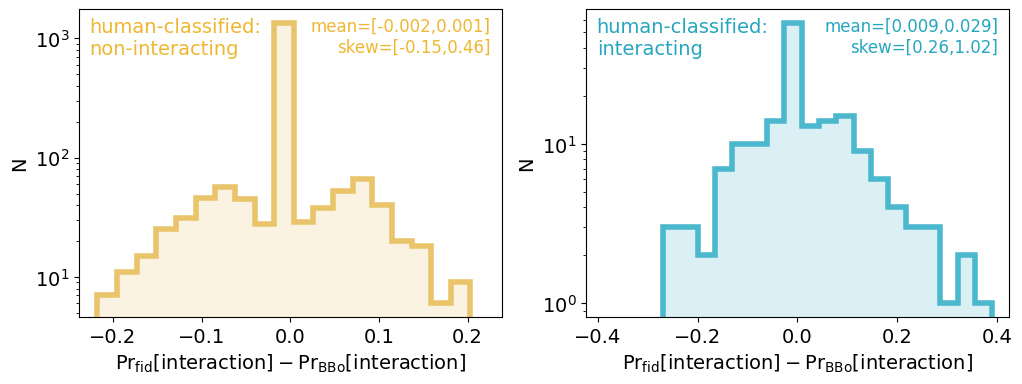

In [341]:
fig, axarr = plt.subplots(1,2,figsize=(12,4))
hkwargs = {'lw':4,'alpha':0.2, 'bins':20}
ek.hist(dp[np.in1d(labels,[1])], ax=axarr[0], color=colorlists.slides['yellow'], **hkwargs)
ek.hist(dp[np.in1d(labels,[2,3])], ax=axarr[1], color=colorlists.slides['blue'], **hkwargs)


cc = [colorlists.slides['yellow'],colorlists.slides['blue']]
prefixes = ['non-','']
lgroups = [[1],[2,3]]
for idx,ax in enumerate(axarr):
    ax.set_yscale('log')
    ax.set_xlim(np.max(np.abs(ax.get_xlim()))*np.array([-1,1]))
    ax.set_ylabel("N")
    ax.set_xlabel(r'$\rm Pr_{fid}[interaction]-Pr_{BBo}[interaction]$')

    mx = sampling.bootstrap_metric( sampling.fmasker(dp[np.in1d(labels,lgroups[idx])]), np.mean )
    sx = sampling.bootstrap_metric( sampling.fmasker(dp[np.in1d(labels,lgroups[idx])]), stats.skew )    
    ek.text(
        0.025, 
        0.975,
        f'''human-classified:
{prefixes[idx]}interacting''',
        ax=ax,
        color=ec.ColorBase(cc[idx]).modulate(-0.1,0.1).base
    )
    ek.text(    
        0.975,
        0.975,
        f'''mean=[{mx[0]:.3f},{mx[1]:.3f}]
skew=[{sx[0]:.2f},{sx[1]:.2f}]''',
        ax=ax,
        color=ec.ColorBase(cc[idx]).modulate(-0.1,0.1).base,
        fontsize=12
    )

plt.savefig('../figures/meanskewness_vs_bbonly.pdf', bbox_inches='tight')

In [354]:
thresh = 0.7
pospos = (pmerger(pfid)>thresh)&(pmerger(pbb)>thresh)
negpos = (pmerger(pbb)>0.5)&(dp<-0.2)&(pbb[:,4]<0.25)
posneg = (pmerger(pfid)>0.7)&(dp>0.2)&(pfid[:,4]<0.25)
negneg = (pmerger(pbb)>thresh)&(pmerger(pbb)<(1.-thresh))

groups = [pospos,negpos,posneg,negneg]
names = ['PP','nP','Pn', 'nn']
long_names = ['both positive',r'$\rm Pr_{fid}[interaction]<Pr_{BBo}[interaction]$', r'$\rm Pr_{fid}[interaction]>Pr_{BBo}[interaction]$', 'both negative']

for _ in range(len(groups)):
    print(f'{names[_]}: {groups[_].sum()}')
    

PP: 2
nP: 16
Pn: 9
nn: 0


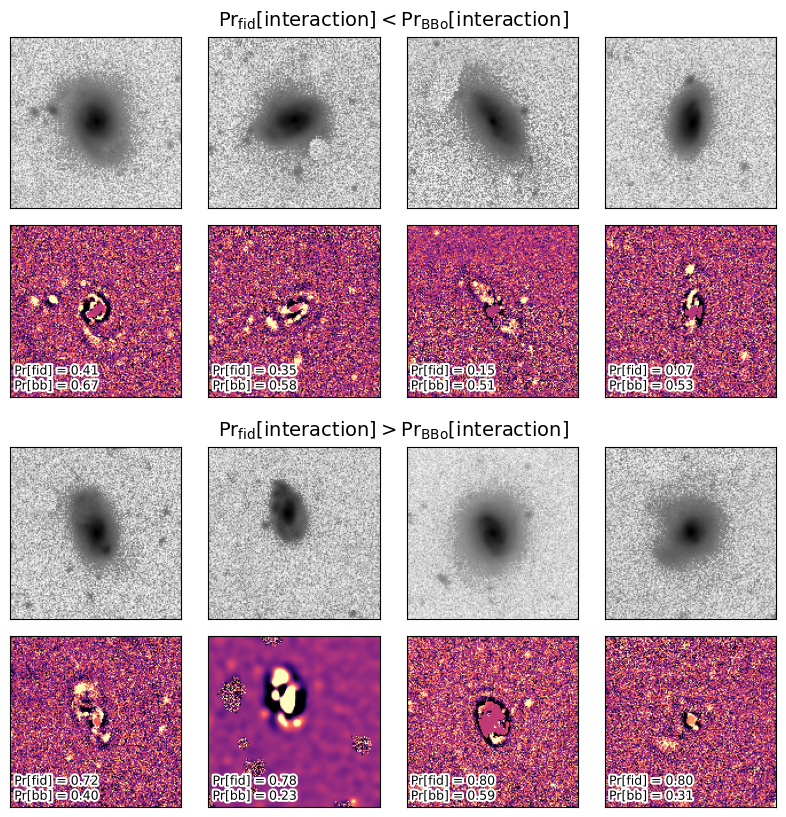

In [360]:
# Create the main figure with dimensions suitable for 2 vertical panels
fig = plt.figure(figsize=(10, 10))

# Create a 2x1 GridSpec for two groups (showing only groups 1 & 2)
outer_grid = gridspec.GridSpec(2, 1, figure=fig, 
                               hspace=0.14)  # Vertical spacing between group panels

# Define which groups to display (0-indexed groups 1 and 2)
groups_to_display = [1, 2]

# Loop through each of the 2 groups
for idx, group_idx in enumerate(groups_to_display):
    # Create a nested 2x6 GridSpec for this group's panel
    # This creates a grid with:
    #   - 2 rows: top row for grayscale images, bottom row for colored images
    #   - 6 columns: one column per example (6 examples total)
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 4,
                                                  subplot_spec=outer_grid[idx],
                                                  hspace=0.1,  # Vertical spacing between subplots
                                                  wspace=0.1)  # Horizontal spacing between subplots
    
    # Get the mask for this group and filter image names
    group_mask = groups[group_idx]
    group_images = img_names[group_mask]
    
    # Randomly select 6 examples from this group (or fewer if not available)
    num_examples = min(4, len(group_images))
    choices = np.random.choice(group_images, num_examples, replace=False)
    
    # Display each selected example in the grid
    # Each column shows one example with grayscale (top) and colored (bottom) versions
    for col in range(num_examples):
        # Load the image data for this example
        img = load_image_by_name(choices[col], data_path)
        
        # Display two versions of the image (grayscale and colored)
        for row in range(2):
            # Create subplot at this row and column
            ax = fig.add_subplot(inner_grid[row, col])
            
            if row == 0:
                # Top row: Display grayscale image with logarithmic normalization
                ax.imshow(
                    img[row + 1],
                    origin='lower',
                    cmap='Greys',
                    norm=colors.SymLogNorm(linthresh=0.1)
                )
            else:
                # Bottom row: Display HF image using ek.imshow
                ek.imshow(
                    img[row + 1],
                    ax=ax,
                    cmap='magma'
                )
                
                # Add probability text overlay (only on the first example)
                img_index = np.where(img_names == choices[col])[0][0]
                ek.text(
                    0.025,  # X position (2.5% from left)
                    0.025,  # Y position (2.5% from bottom)
                    rf'''Pr[fid] = {pmerger(pfid)[img_index]:.2f}
Pr[bb] = {pmerger(pbb)[img_index]:.2f}''',
                    ax=ax,
                    fontsize=9,
                    bordercolor='w',
                    color='k',
                    borderwidth=3
                )
            
            # Remove axis ticks for cleaner appearance
            ax.set_xticks([])
            ax.set_yticks([])

    
    # Add title above this group's panel
    bbox = outer_grid[idx].get_position(fig)
    fig.text(
        bbox.x0 + bbox.width / 2,  # Center horizontally
        bbox.y1 +0.005,             # Slightly above the panel
        f'{long_names[group_idx]}',
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold'
    )

plt.savefig('../figures/pfid_pbb_comparison.pdf', bbox_inches='tight')

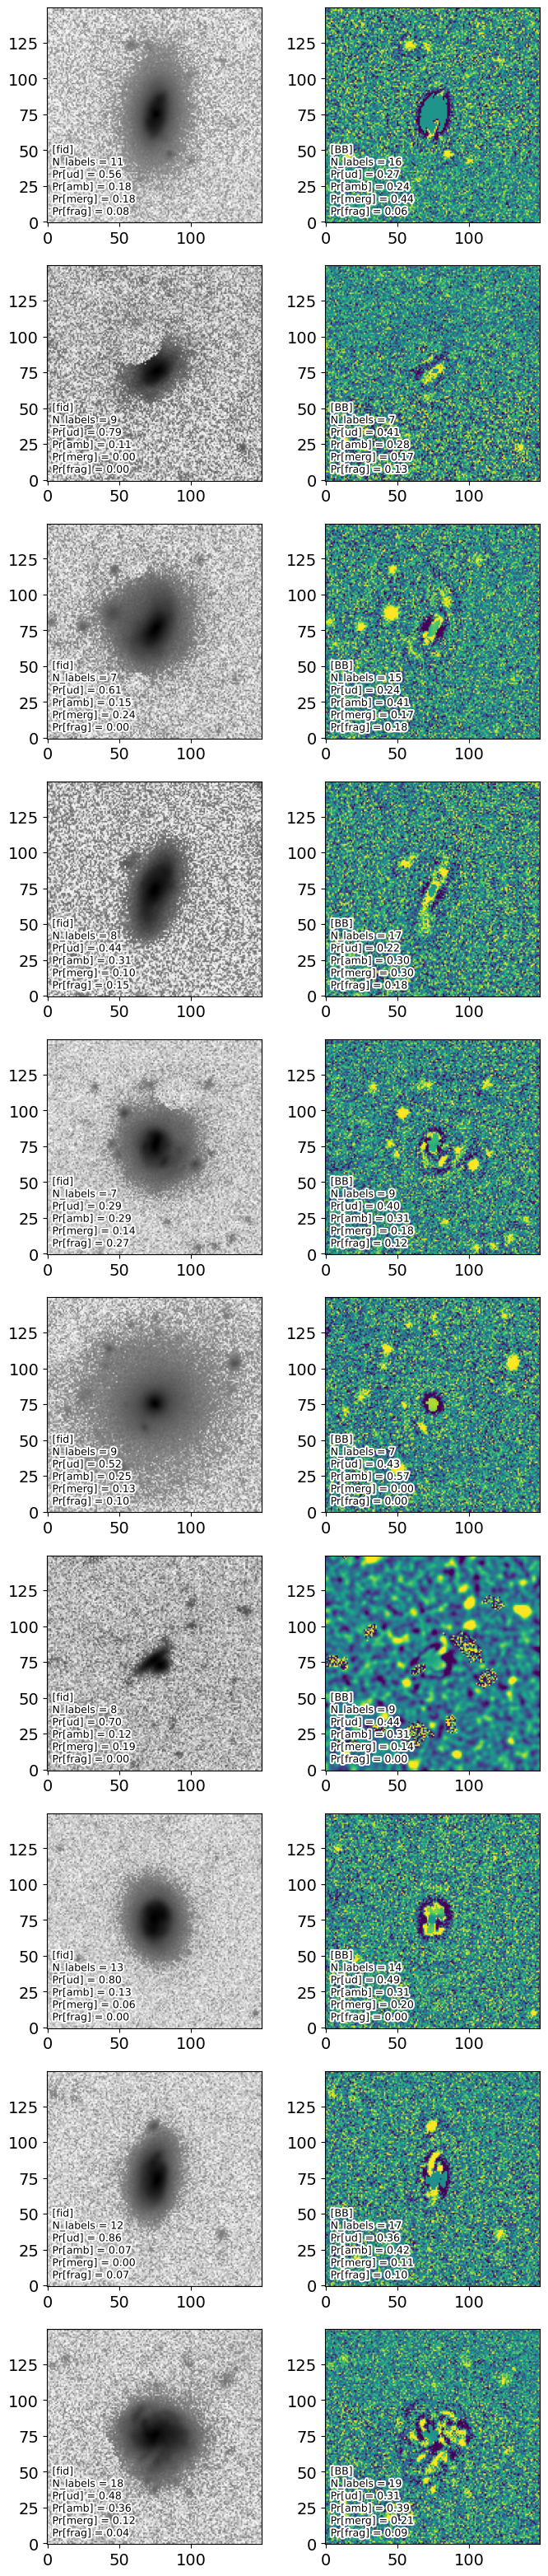

In [82]:
candidates = ~data['fiducial']['is_possible_merger'] & data['bbonly']['is_possible_merger']
n_candidates = min(10,(candidates).sum())

pfid = data['fiducial']['prob_labels']
pbb  = data['bbonly']['prob_labels']

nfid = data['fiducial']['n_labels']
nbb  = data['bbonly']['n_labels']

fig, axarr = plt.subplots(n_candidates,2,figsize=(8,4*n_candidates))
for adx,idx in enumerate(np.random.choice(np.arange(len(img_names))[candidates], replace=False, size=n_candidates)):
    img = load_image_by_name(img_names[idx], data_path)
    
    axarr[adx, 0].imshow(
        img[1],
        origin='lower',
        cmap='Greys',
        norm=colors.SymLogNorm(linthresh=0.1)
    )
    ek.imshow(img[2], ax=axarr[adx,1])

    # Add statistics
    ek.text(
        0.025, 0.025,
        f"""[fid]
N_labels = {nfid[idx]}
Pr[ud] = {pfid[idx, 1]:.2f}
Pr[amb] = {pfid[idx, 2]:.2f}
Pr[merg] = {pfid[idx, 3]:.2f}
Pr[frag] = {pfid[idx, 4]:.2f}""",
        ax=axarr[adx,0],
        fontsize=9,
        bordercolor='w',
        color='k',
        borderwidth=3
    )
    # Add statistics
    ek.text(
        0.025, 0.025,
        f"""[BB]
N_labels = {nbb[idx]}
Pr[ud] = {pbb[idx, 1]:.2f}
Pr[amb] = {pbb[idx, 2]:.2f}
Pr[merg] = {pbb[idx, 3]:.2f}
Pr[frag] = {pbb[idx, 4]:.2f}""",
        ax=axarr[adx,1],
        fontsize=9,
        bordercolor='w',
        color='k',
        borderwidth=3
    )    

In [86]:
manual_merger = (labels==2)|(labels==3)

In [105]:
pmerger = lambda x: np.where(x[:,4]<0.2, x[:,2]+x[:,3], np.nan)

In [99]:
# Identify mergers based on probability labels
prob_labels_iter = data['fiducial']['prob_labels']
fragmented = prob_labels_iter[:, 4] > 0.2
possible_merger = (prob_labels_iter[:, 2] + prob_labels_iter[:, 3]) > prob_labels_iter[:, 1]

is_merger = possible_merger & ~fragmented
is_undisturbed = ~possible_merger & ~fragmented

In [132]:
np.in1d(labels, [2,3]).sum() / (labels>0).sum()

0.10497798848628513

In [127]:
np.nanmean(np.where(data['fiducial']['prob_labels'][:,4]<0.2, data['fiducial']['prob_labels'][:,2] + data['fiducial']['prob_labels'][:,3], np.nan))

0.0412602112095324

(<Axes: >,
 (array([6.37681159, 2.70531401, 1.83574879, 1.54589372, 1.83574879,
         1.15942029, 0.57971014, 1.15942029, 1.25603865, 0.48309179,
         0.28985507, 0.28985507, 0.19323671, 0.        , 0.09661836,
         0.09661836, 0.09661836, 0.        , 0.        , 0.        ,
         0.        ]),
  array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
  [<matplotlib.patches.Polygon at 0x33ef4caf0>]))

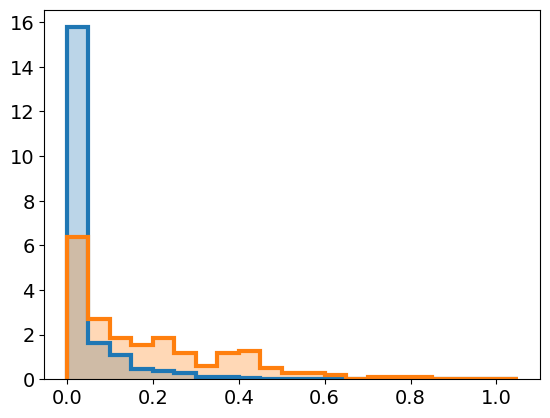

In [114]:
hkwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0., 1.1, 0.05), 'density': True}

ek.hist(pmerger(data['fiducial']['prob_labels'])[manual_nonmerger], **hkwargs)
ek.hist(pmerger(data['fiducial']['prob_labels'])[manual_merger], **hkwargs)

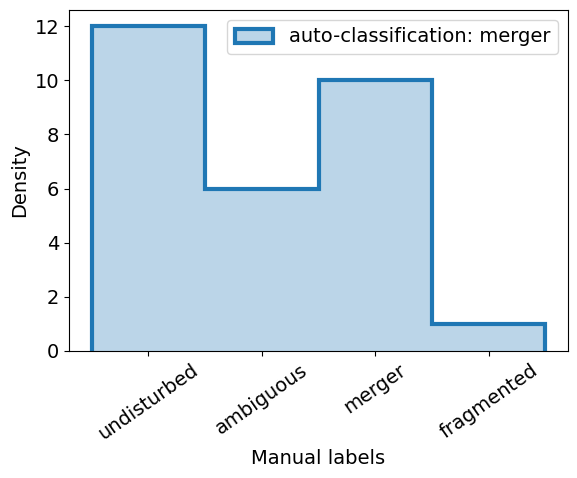

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# Compare with manual labels
if (labels > 0).any():    
    # Create contingency table
    manual_merger = (labels == 3) | (labels == 2)  # merger or ambiguous
    manual_nonmerger = labels == 1  # undisturbed
    
    hist_kwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0.5, 5.5), 'density': False}
    
    #ek.hist(labels[is_undisturbed], ax=ax, label='auto-classification: not merger', **hist_kwargs)
    ek.hist(labels[is_merger], ax=ax, label='auto-classification: merger', **hist_kwargs)
    
    ax.set_xticks(np.arange(1,5),['undisturbed', 'ambiguous', 'merger', 'fragmented'], rotation=35)
    ax.set_xlabel('Manual labels')
    ax.set_ylabel('Density')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## Compute Classification Metrics

In [ ]:
# Compute metrics on TEST SET for both experiments
class_names = {i: name for i, name in config['labels']['label_mapping'].items()}

for name in data.keys():
    print(f"\n{'='*70}")
    print(f"Metrics: {name}")
    print(f"{'='*70}")
    
    # Hard classification (argmax)
    prob_labels = data[name]['prob_labels']
    final_predictions = np.argmax(prob_labels, axis=1)
    
    metrics = compute_classification_metrics(
        labels[test_mask],
        final_predictions[test_mask],
        class_names
    )
    
    data[name]['metrics'] = metrics
    
    print(f"\nTest Set Performance:")
    print(f"   Overall Purity: {metrics['overall_purity']:.4f}")
    print(f"   Overall Completeness: {metrics['overall_completeness']:.4f}")
    print(f"   Accuracy: {metrics['classification_report']['accuracy']:.4f}")
    print(f"   Precision (weighted): {metrics['classification_report']['weighted avg']['precision']:.4f}")
    print(f"   Recall (weighted): {metrics['classification_report']['weighted avg']['recall']:.4f}")
    print(f"   F1-score (weighted): {metrics['classification_report']['weighted avg']['f1-score']:.4f}")

print("\n✅ Metrics computed for all experiments")

## Comparison Visualizations

### Metric Comparison

In [ ]:
# Compare key metrics side-by-side
metric_names = ['overall_purity', 'overall_completeness', 'accuracy', 'precision', 'recall', 'f1_score']
exp_names = list(data.keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(metric_names))
width = 0.35

for idx, name in enumerate(exp_names):
    metrics = data[name]['metrics']
    values = [
        metrics['overall_purity'],
        metrics['overall_completeness'],
        metrics['classification_report']['accuracy'],
        metrics['classification_report']['weighted avg']['precision'],
        metrics['classification_report']['weighted avg']['recall'],
        metrics['classification_report']['weighted avg']['f1-score']
    ]
    
    offset = width * (idx - len(exp_names)/2 + 0.5)
    ax.bar(x + offset, values, width, label=experiments[name]['label'], 
           color=experiments[name]['color'], alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Classification Metrics Comparison (Test Set)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Purity', 'Completeness', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], rotation=45, ha='right')
ax.set_ylim(0, 1.05)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Metric comparison plot generated")

### Probability Distribution Comparison

In [ ]:
# Compare probability distributions for key classes
key_classes = [1, 2, 3, 4]  # undisturbed, ambiguous, merger, fragmentation
class_labels = [class_names[i] for i in key_classes]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for class_idx, class_id in enumerate(key_classes):
    ax = axes[class_idx]
    
    for name in exp_names:
        prob_labels = data[name]['prob_labels']
        class_probs = prob_labels[test_mask, class_id]
        
        ax.hist(
            class_probs,
            bins=np.linspace(0, 1, 30),
            alpha=0.5,
            label=experiments[name]['label'],
            color=experiments[name]['color'],
            density=True
        )
    
    ax.set_xlabel(f'Pr[{class_labels[class_idx]}]', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Class: {class_labels[class_idx]}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('Probability Distribution Comparison (Test Set)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n📊 Probability distribution plots generated")

### Direct Probability Comparison (Scatter Plots)

In [ ]:
# Compare probabilities directly between experiments
if len(exp_names) == 2:
    exp1, exp2 = exp_names
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for class_idx, class_id in enumerate(key_classes):
        ax = axes[class_idx]
        
        prob1 = data[exp1]['prob_labels'][test_mask, class_id]
        prob2 = data[exp2]['prob_labels'][test_mask, class_id]
        
        # 2D histogram
        h = ax.hist2d(
            prob1, prob2,
            bins=30,
            range=[[0, 1], [0, 1]],
            cmap='Blues',
            cmin=1
        )
        
        # Add diagonal line
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, lw=2, label='y=x')
        
        # Compute correlation
        corr = np.corrcoef(prob1, prob2)[0, 1]
        
        ax.set_xlabel(f'{experiments[exp1]["label"]}\nPr[{class_labels[class_idx]}]', fontsize=10)
        ax.set_ylabel(f'{experiments[exp2]["label"]}\nPr[{class_labels[class_idx]}]', fontsize=10)
        ax.set_title(f'{class_labels[class_idx]}\nCorrelation: {corr:.3f}', fontsize=11, fontweight='bold')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.legend(fontsize=9)
        
        plt.colorbar(h[3], ax=ax, label='Count')
    
    plt.suptitle('Direct Probability Comparison (Test Set)', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Scatter plot comparison generated")
else:
    print("⏭️  Skipping scatter plots (need exactly 2 experiments)")

### PCA Embedding Comparison

In [ ]:
# Compare PCA embeddings
fig, axes = plt.subplots(1, len(exp_names), figsize=(7*len(exp_names), 6))
if len(exp_names) == 1:
    axes = [axes]

for idx, name in enumerate(exp_names):
    ax = axes[idx]
    
    embeddings_pca = data[name]['embeddings_pca']
    
    # Color by true labels for test set
    scatter = ax.scatter(
        embeddings_pca[test_mask, 0],
        embeddings_pca[test_mask, 1],
        c=labels[test_mask],
        cmap='tab10',
        alpha=0.6,
        s=20,
        vmin=0,
        vmax=5
    )
    
    ax.set_xlabel('PC1', fontsize=12)
    ax.set_ylabel('PC2', fontsize=12)
    ax.set_title(f'{experiments[name]["label"]}\nPCA Embeddings (Test Set)', 
                 fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    
    if idx == len(exp_names) - 1:
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('True Label', fontsize=11)

plt.tight_layout()
plt.show()

print("\n📊 PCA embedding comparison generated")

## Summary Statistics

In [ ]:
# Print summary table
print("\n" + "="*80)
print("COMPARISON SUMMARY (Test Set)")
print("="*80)

summary_data = []
for name in exp_names:
    metrics = data[name]['metrics']
    stats = data[name]['stats']
    
    summary_data.append({
        'Experiment': experiments[name]['label'],
        'Accuracy': f"{metrics['classification_report']['accuracy']:.4f}",
        'Precision': f"{metrics['classification_report']['weighted avg']['precision']:.4f}",
        'Recall': f"{metrics['classification_report']['weighted avg']['recall']:.4f}",
        'F1-Score': f"{metrics['classification_report']['weighted avg']['f1-score']:.4f}",
        'Purity': f"{metrics['overall_purity']:.4f}",
        'Completeness': f"{metrics['overall_completeness']:.4f}",
        'Auto-labels': stats['n_added_iteration']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print(f"Configuration: k={analysis_config['n_neighbors']}, "
      f"n_min={analysis_config['n_min']}, "
      f"PCA={analysis_config['pca_components']} components")
print(f"Train/Test split: {train_mask.sum()}/{test_mask.sum()} (seed={analysis_config['random_seed']})")
print("="*80)

## Export Results

In [ ]:
# Optional: Save comparison results
save_results = False  # Set to True to save

if save_results:
    output_dir = Path('../output/comparisons')
    output_dir.mkdir(exist_ok=True)
    
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    output_file = output_dir / f'comparison_{timestamp}.pkl'
    
    comparison_results = {
        'experiments': experiments,
        'config': analysis_config,
        'data': data,
        'train_mask': train_mask,
        'test_mask': test_mask,
        'labels': labels,
        'img_names': img_names,
        'summary': summary_df
    }
    
    with open(output_file, 'wb') as f:
        pickle.dump(comparison_results, f)
    
    print(f"✅ Results saved to: {output_file}")
else:
    print("⏭️  Skipping save (set save_results=True to save)")